# short_test.ipynb
Functions to examine rolling correlations between device sensor outputs.

Authors:  
– Jon Clucas, 2017 jon.clucas@childmind.org  
– Arno Klein, 2017  
© 2017, Child Mind Institute, Apache v2.0 License

setup:

In [1]:
%matplotlib inline
from annotate_range import annotation_line
from astropy.stats import median_absolute_deviation as mad
from chart_data import bland_altman_plot, df_devices, linechart, rolling_window, write_csv, xcorr
from config import short_dir, test_urls
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from normalize_acc_data import actigraph_acc, geneactiv_acc
from plot_normalized_vector_lengths import baseshift_and_renormalize
from utilities.fetch_data import fetch_check_data, fetch_data, fetch_hash
import json, matplotlib as mpl, numpy as np, os, pandas as pd, matplotlib.pyplot as plt
"""
with open(os.path.join('./line_charts/device_colors.json')) as fp:
    color_key = json.load(fp)
"""
pd.set_option('mode.use_inf_as_null', True)
acc_hashes = {'G1_acc_quicktest': '81649fc8a11bf2e87519fa5bb6c0b1f8',
              'A_acc_quicktest': '083a9ec701d94474558618a3b303b0cc',
              'G2_acc_quicktest': 'a23bb0267c79451026b221434ef025ba'}
if not os.path.exists('./sample_data'):
    os.makedirs('./sample_data')

load normalized data:

In [3]:
df = df_devices([('A', 'ActiGraph'), ('G1', 'GENEActiv'), ('G2', 'GENEActiv')], 'accelerometer',
     datetime(2017, 4, 28, 15, 30), datetime(2017, 4, 28, 15, 48))
df.rename(columns={'normalized_vector_length': 'normalized_vector_length_GENEActiv(2)'}, inplace=True)

Retrieve file from URL: https://osf.io/h3aem/?action=download&version=1
Copy file to cache: ./sample_data/083a9ec701d94474558618a3b303b0cc/A_acc_quicktest.csv
Create missing hash directory: ./sample_data/81649fc8a11bf2e87519fa5bb6c0b1f8
Retrieve file from URL: https://osf.io/j5rcu/?action=download&version=1
Copy file to cache: ./sample_data/81649fc8a11bf2e87519fa5bb6c0b1f8/G1_acc_quicktest.csv
Create missing hash directory: ./sample_data/a23bb0267c79451026b221434ef025ba
Retrieve file from URL: https://osf.io/yxgzt/?action=download&version=1
Copy file to cache: ./sample_data/a23bb0267c79451026b221434ef025ba/G2_acc_quicktest.csv


linechart(df, 'ActiGraph vs 2×GENEActiv', line=True, full=True)

linechart(df, 'ActiGraph vs 2×GENEActiv', line=False, full=True)

In [4]:
Avalues = df['normalized_vector_length_ActiGraph'].values
G1values = df['normalized_vector_length_GENEActiv'].values
G2values = df['normalized_vector_length_GENEActiv(2)'].values

shiftG1G2 = len(G1values) - np.argmax(np.correlate(G1values, G2values, mode='full'))
shiftG1A = len(G1values) - np.argmax(np.correlate(G1values, Avalues, mode='full'))
shiftG2A = len(G2values) - np.argmax(np.correlate(G2values, Avalues, mode='full'))
shiftGA = np.int(np.mean([shiftG1A, shiftG2A]))
[shiftG1G2, shiftG1A, shiftG2A, shiftGA]

In [6]:
shift_GA = np.abs(shiftGA)
Avalues_shifted = Avalues[:G1values.shape[0]-shift_GA]
G1values_shifted = G1values[shift_GA:G1values.shape[0]]
G2values_shifted = G2values[shift_GA:G2values.shape[0]]
[np.shape(G1values_shifted), np.shape(G2values_shifted), np.shape(Avalues_shifted)]

In [8]:
[xcorr(G1values_shifted, G2values_shifted), xcorr(Avalues_shifted, G1values_shifted),
 xcorr(Avalues_shifted, G2values_shifted)]

[array([ 0.66798282]), array([ 0.96291413]), array([ 0.75040079])]

In [9]:
shifted_t = [datetime(2017, 4, 28, 15, 30)]
while len(shifted_t) < np.shape(Avalues_shifted)[0]:
    shifted_t.append(shifted_t[-1] + timedelta(seconds=0.0166))
shifted_df = pd.DataFrame({'normalized_vector_length_ActiGraph': Avalues_shifted,
            'normalized_vector_length_GENEActiv': G1values_shifted,
            'normalized_vector_length_GENEActiv(2)': G2values_shifted, 'Timestamp':shifted_t})
shifted_df.set_index('Timestamp', inplace=True)

start = shifted_t[0]
stop = shifted_t[-1]
while start < stop:
    new_start = start + timedelta(seconds=180)
    plot_df = shifted_df.loc[(shifted_df.index >= start) & (shifted_df.index <= new_start)].copy()
    label = '–'.join([start.strftime('%H:%M:%S'), new_start.strftime('%H:%M:%S')])
    linechart(plot_df, label, False)
    print(xcorr(plot_df['normalized_vector_length_GENEActiv'].values,
                plot_df['normalized_vector_length_GENEActiv(2)'].values))
    print(xcorr(plot_df['normalized_vector_length_ActiGraph'].values,
                plot_df['normalized_vector_length_GENEActiv'].values))
    print(xcorr(plot_df['normalized_vector_length_ActiGraph'].values,
                plot_df['normalized_vector_length_GENEActiv(2)'].values))
    start = new_start

linechart(shifted_df, 'ActiGraph vs 2×GENEActiv, shifted', line=False, full=True)

linechart(shifted_df, 'ActiGraph vs 2×GENEActiv, shifted', line=True, full=True)

cut middle portion out when devices were being transferred:

In [10]:
start1 = datetime(2017,4,28,15,30)
stop1 = datetime(2017,4,28,15,37)
start2 = datetime(2017,4,28,15,40)
stop2 = datetime(2017,4,28,15,48)
cropped_df = shifted_df.loc[(shifted_df.index >= start1) & (shifted_df.index <= stop1) |
                            (shifted_df.index >= start2) & (shifted_df.index <= stop2)].copy()

Plotting...
ActiGraph vs 2×GENEActiv, shifted, cropped section
0.0139888028474
0.00998218492143
0.00838121364074


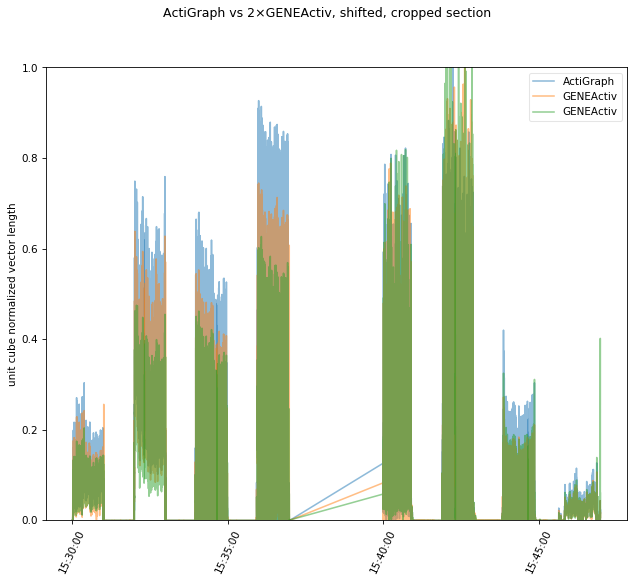

True

In [11]:
linechart(cropped_df, 'ActiGraph vs 2×GENEActiv, shifted, cropped section', line=True, full=True)

In [12]:
Avalues_cropped = cropped_df['normalized_vector_length_ActiGraph'].values
G1values_cropped = cropped_df['normalized_vector_length_GENEActiv'].values
G2values_cropped = cropped_df['normalized_vector_length_GENEActiv(2)'].values

compute normalized cross-correlations:

In [13]:
[xcorr(G1values_cropped, G2values_cropped), xcorr(Avalues_cropped, G1values_cropped),
 xcorr(Avalues_cropped, G2values_cropped)]

[array([ 0.65022666]), array([ 0.96125146]), array([ 0.73665921])]

plot x-second windows:

Plotting...
15:30:00–15:30:10
0.0437178370142
0.0364799244892
0.0301341948681


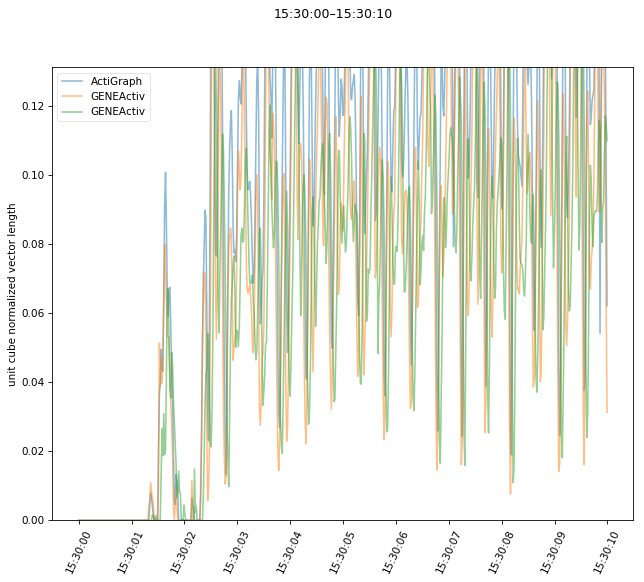

Plotting...
15:30:10–15:30:20
0.0323198690038
0.0307621471261
0.0213744191102


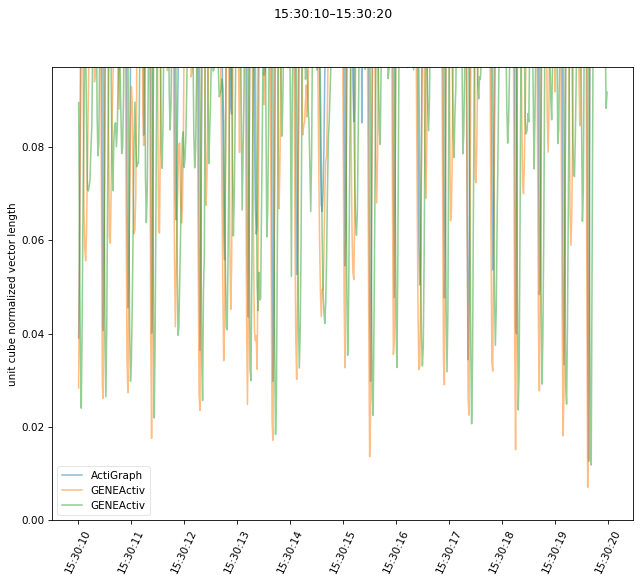

Plotting...
15:30:20–15:30:30
0.0289504319834
0.0236504075344
0.0190238713984


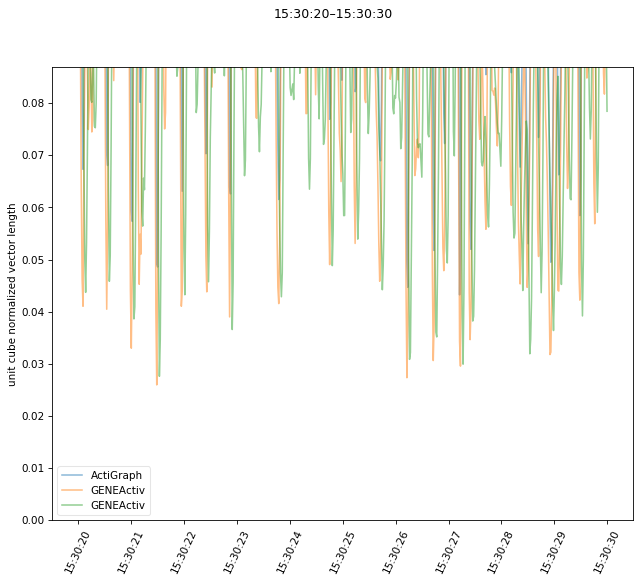

Plotting...
15:30:30–15:30:40
0.0286845763142
0.0231750334311
0.0188346442849


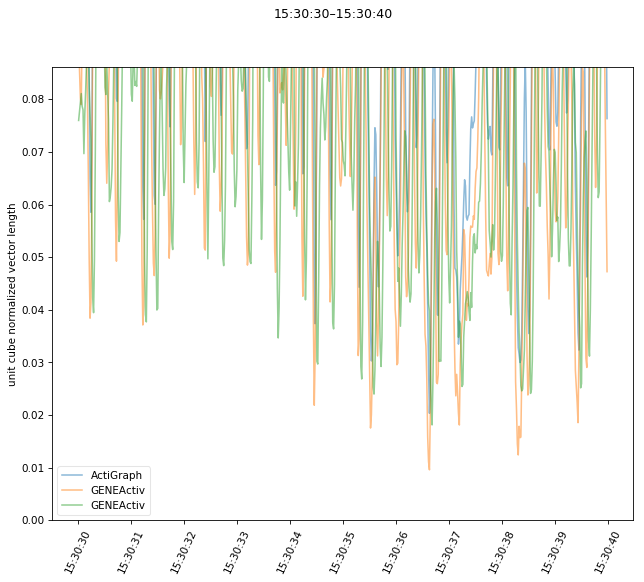

Plotting...
15:30:40–15:30:50
0.0245804337362
0.0198559001691
0.0150563955372


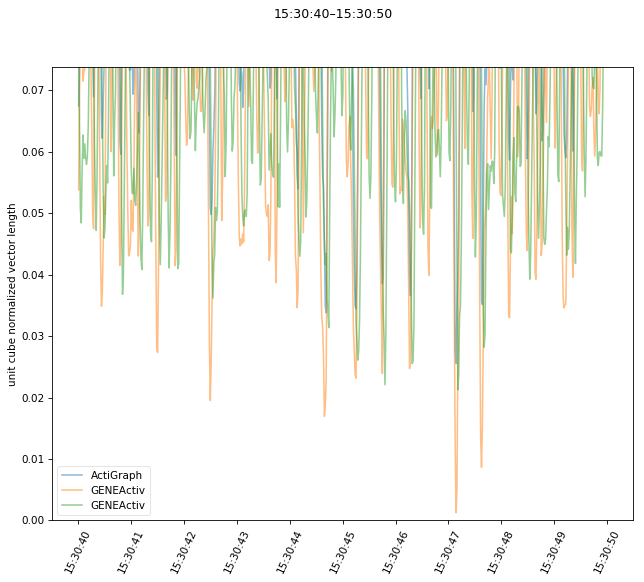

Plotting...
15:30:50–15:31:00
0.022403687886
0.0196628536227
0.0140059905292


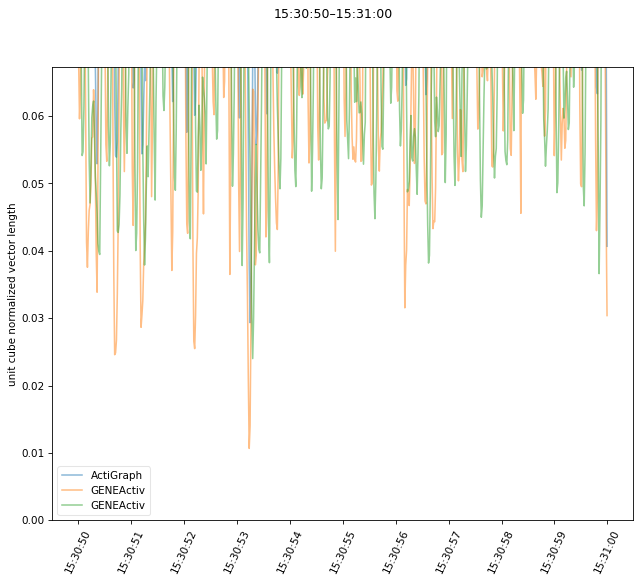

Plotting...
15:31:00–15:31:10
0.0113948362006
0.0142507341521
0.0127523522314


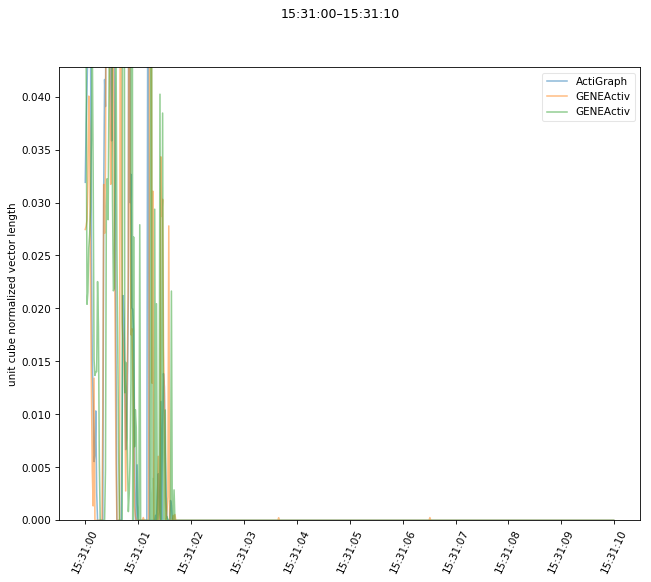

Plotting...
15:31:10–15:31:20
normalized_vector_length_ActiGraph
1.42850611308e-05
normalized_vector_length_GENEActiv(2)


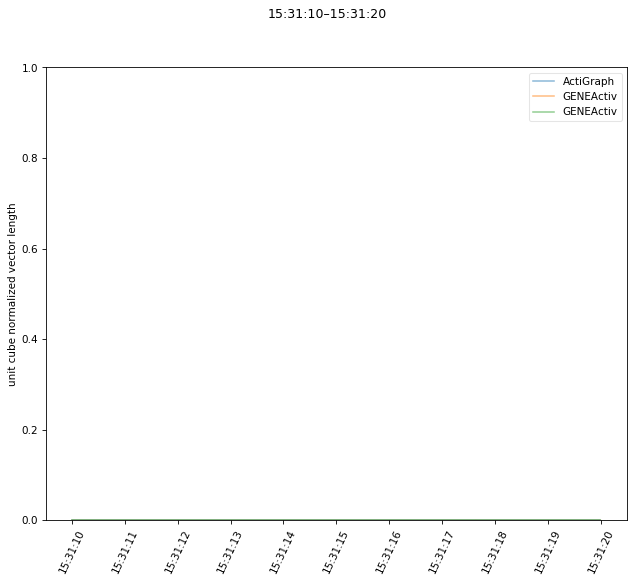

Plotting...
15:31:20–15:31:30
normalized_vector_length_ActiGraph
1.45722408337e-05
normalized_vector_length_GENEActiv(2)


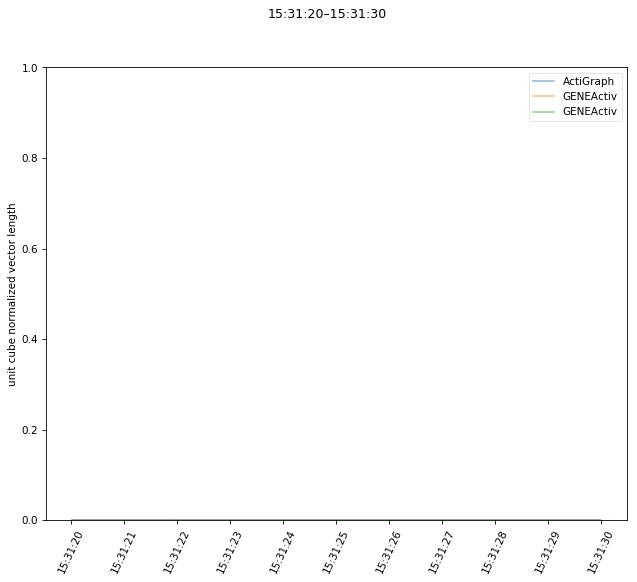

Plotting...
15:31:30–15:31:40
normalized_vector_length_ActiGraph
2.70267796214e-05
normalized_vector_length_GENEActiv(2)


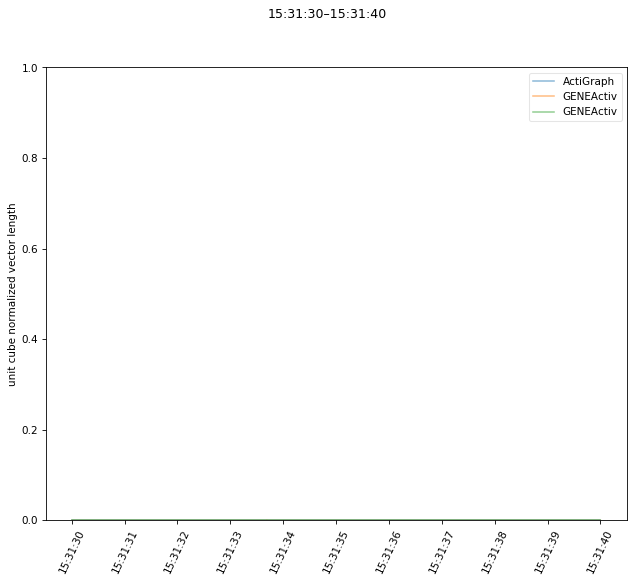

Plotting...
15:31:40–15:31:50
normalized_vector_length_ActiGraph
1.46795743606e-05
normalized_vector_length_GENEActiv(2)


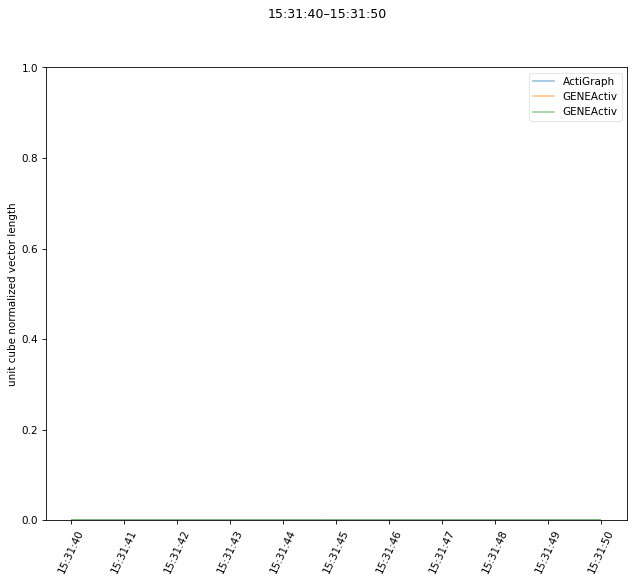

Plotting...
15:31:50–15:32:00
0.0188450489456
0.0149756963947
0.0118258407945


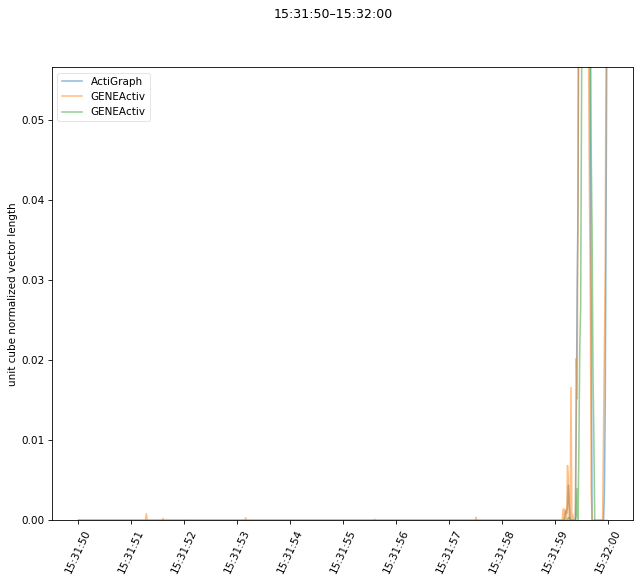

Plotting...
15:32:00–15:32:10
0.0973133902923
0.0751143294076
0.0588221644197


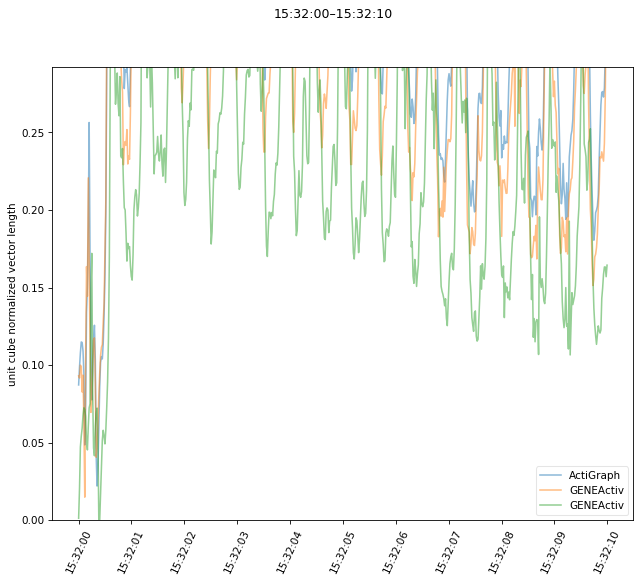

Plotting...
15:32:10–15:32:20
0.082202389402
0.0587771202649
0.0527122818202


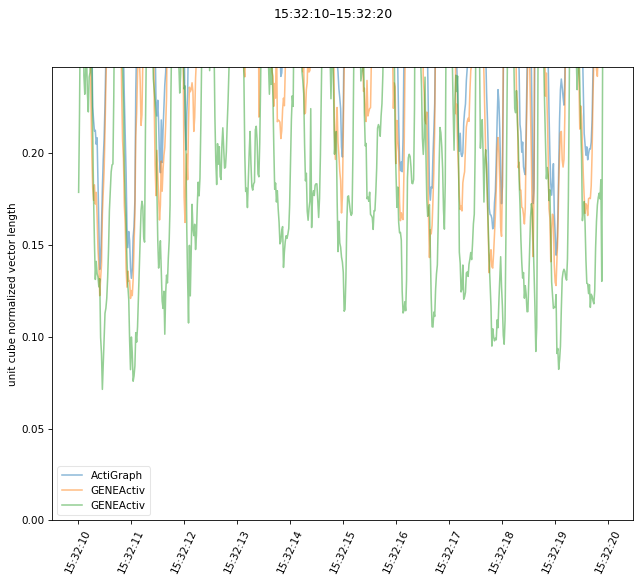

Plotting...
15:32:20–15:32:30
0.0761733319033
0.0583304137607
0.0456404365888


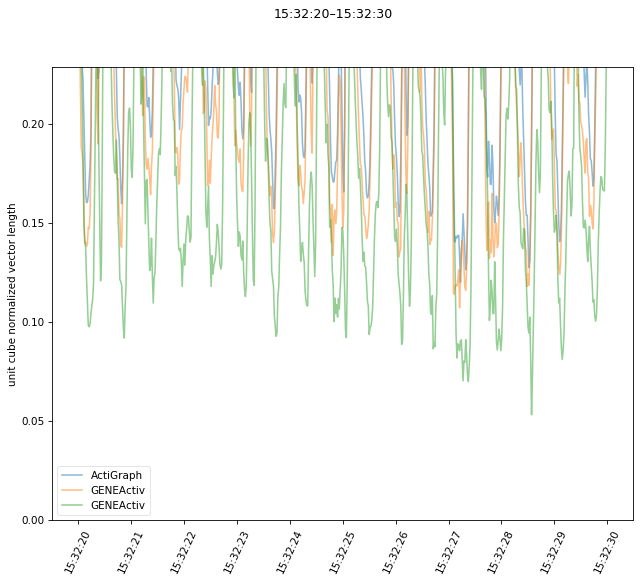

Plotting...
15:32:30–15:32:40
0.0728434394961
0.0554133605609
0.0444676339507


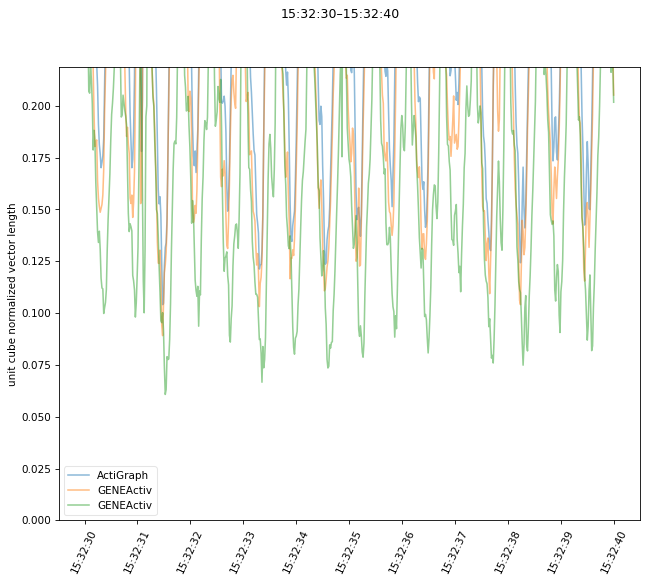

Plotting...
15:32:40–15:32:50
0.0740899337213
0.0546103584088
0.0457503376028


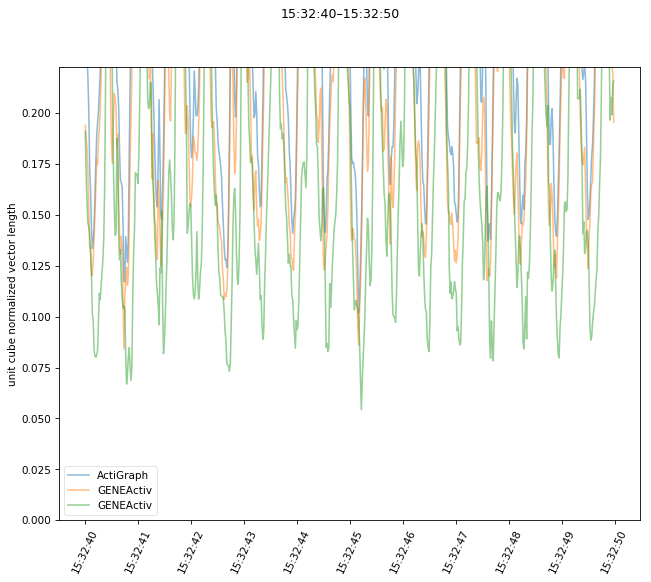

Plotting...
15:32:50–15:33:00
0.0737384633957
0.0562647059042
0.0450074222863


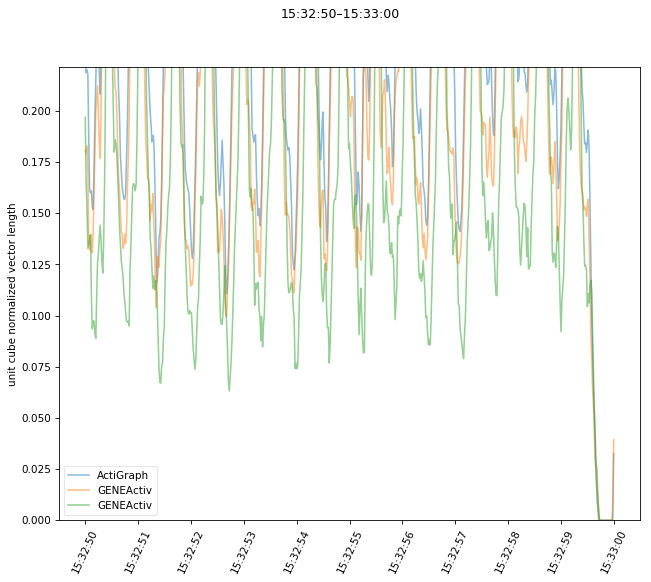

Plotting...
15:33:00–15:33:10
0.0203230006757
0.028856729563
0.0187489778063


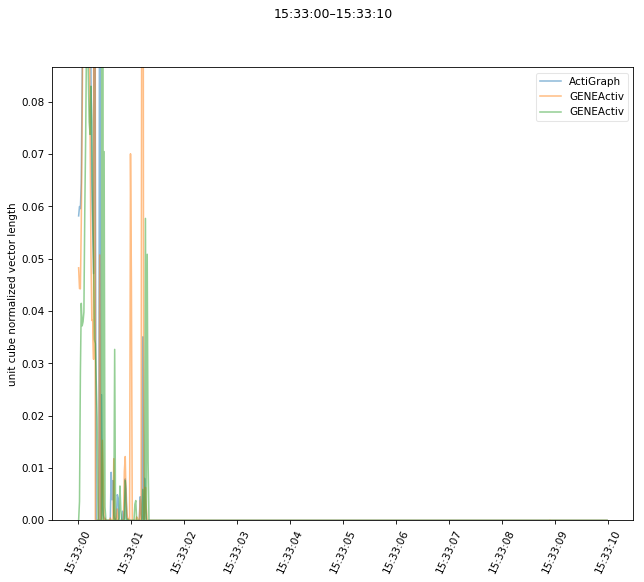

Plotting...
15:33:10–15:33:20
normalized_vector_length_ActiGraph
normalized_vector_length_GENEActiv
normalized_vector_length_GENEActiv(2)


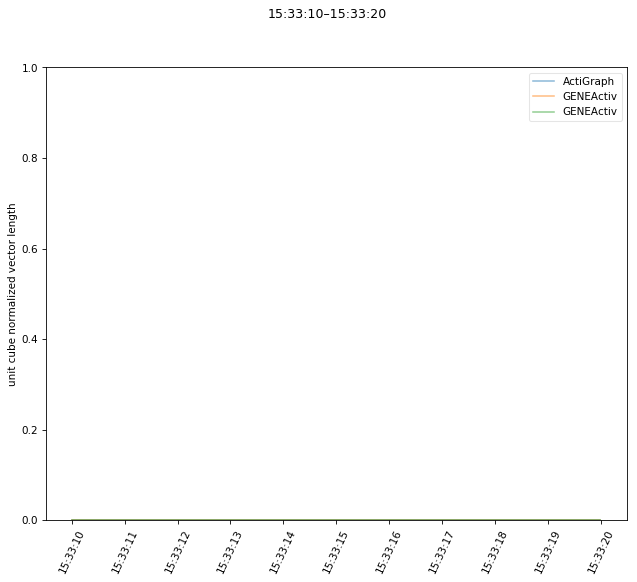

Plotting...
15:33:20–15:33:30
normalized_vector_length_ActiGraph
2.41809930836e-05
normalized_vector_length_GENEActiv(2)


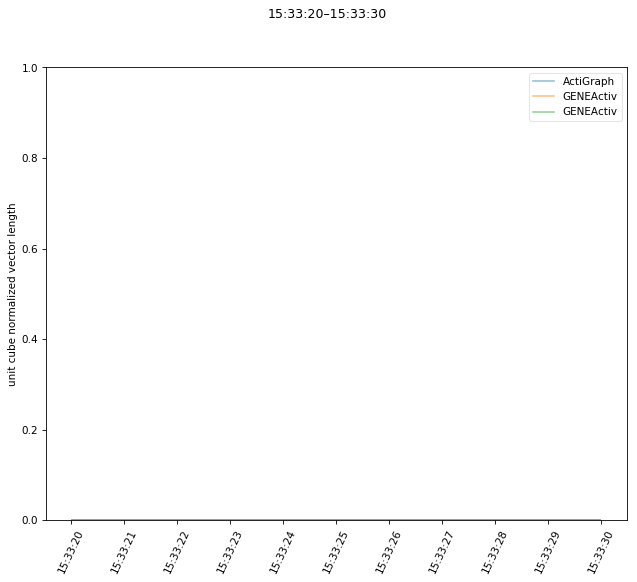

Plotting...
15:33:30–15:33:40
normalized_vector_length_ActiGraph
1.55252268186e-05
normalized_vector_length_GENEActiv(2)


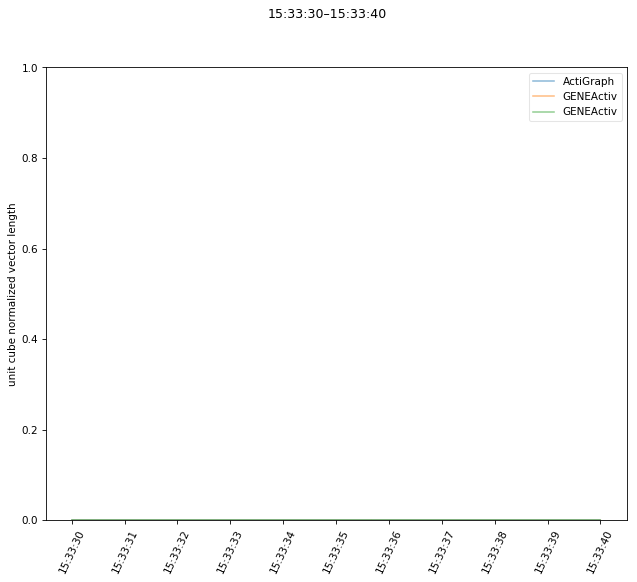

Plotting...
15:33:40–15:33:50
normalized_vector_length_ActiGraph
4.86096315673e-06
normalized_vector_length_GENEActiv(2)


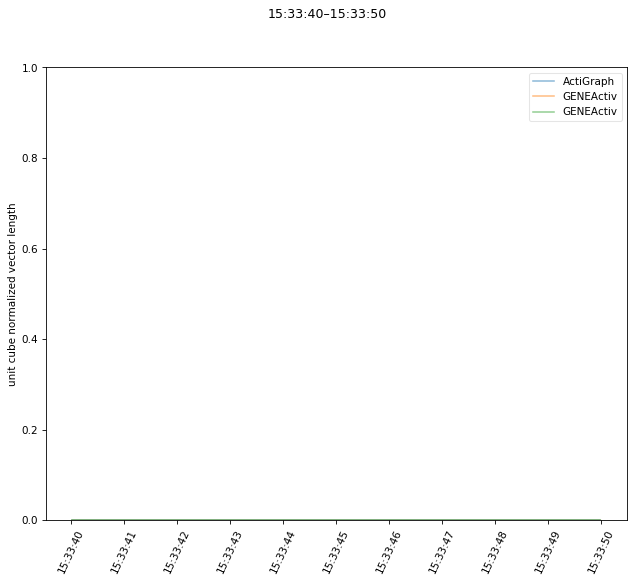

Plotting...
15:33:50–15:34:00
0.108990592958
0.0849765725716
0.0748973848177


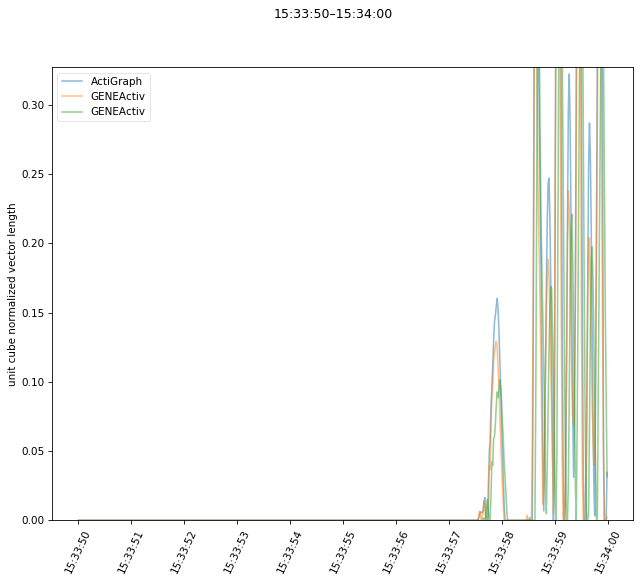

Plotting...
15:34:00–15:34:10
0.130167200901
0.0909605725907
0.0916633405269


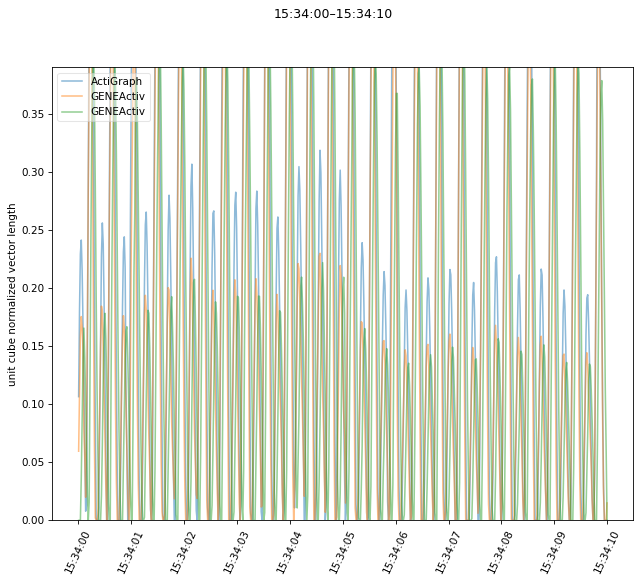

Plotting...
15:34:10–15:34:20
0.0996428069058
0.0660069346877
0.0733978578513


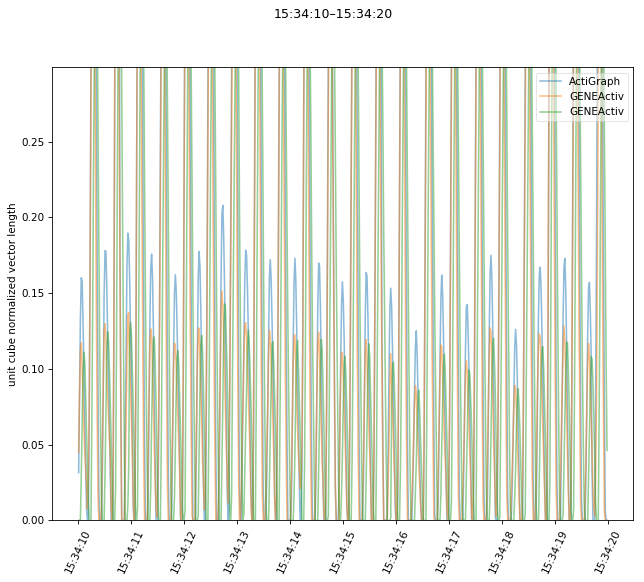

Plotting...
15:34:20–15:34:30
0.103094696815
0.0676858520645
0.0688098961058


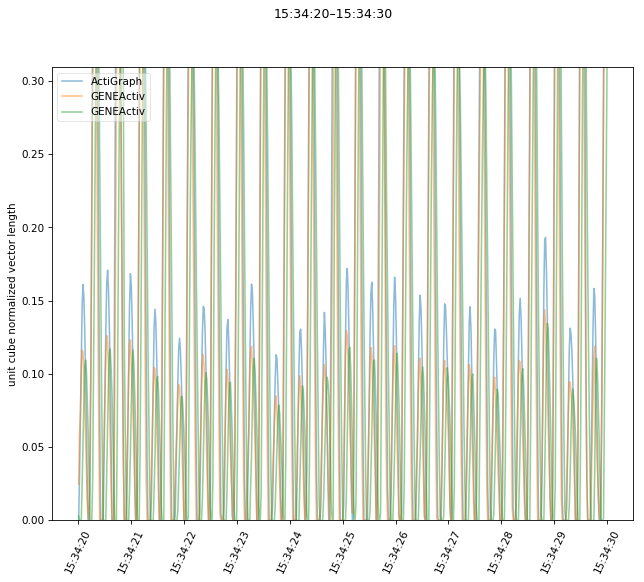

Plotting...
15:34:30–15:34:40
0.0860379796978
0.0605309891905
0.0585469084221


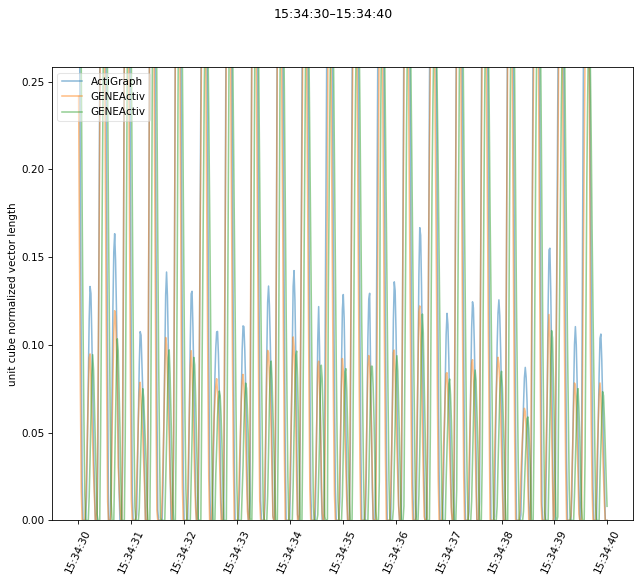

Plotting...
15:34:40–15:34:50
0.0796516073972
0.0602750651335
0.0556924810078


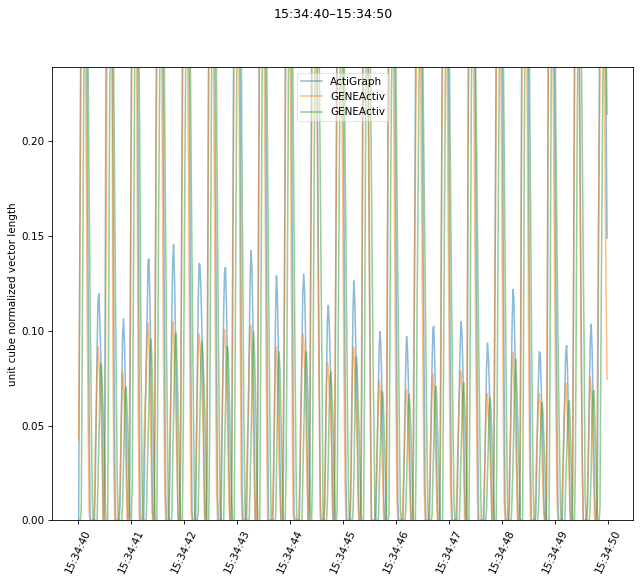

Plotting...
15:34:50–15:35:00
0.0498785728861
0.0403279193657
0.0373084138618


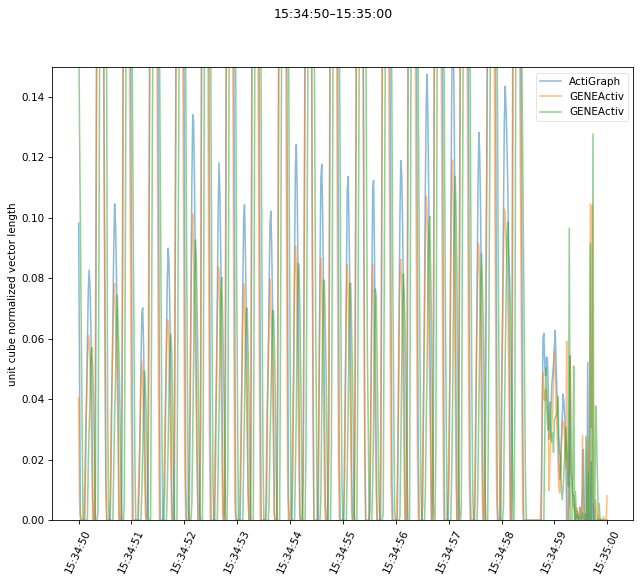

Plotting...
15:35:00–15:35:10
normalized_vector_length_ActiGraph
0.000305985892981
8.96370859182e-05


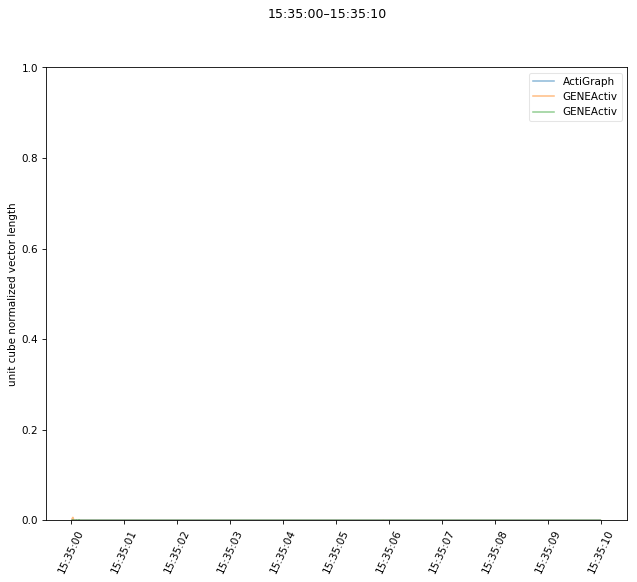

Plotting...
15:35:10–15:35:20
normalized_vector_length_ActiGraph
1.6507798674e-05
normalized_vector_length_GENEActiv(2)


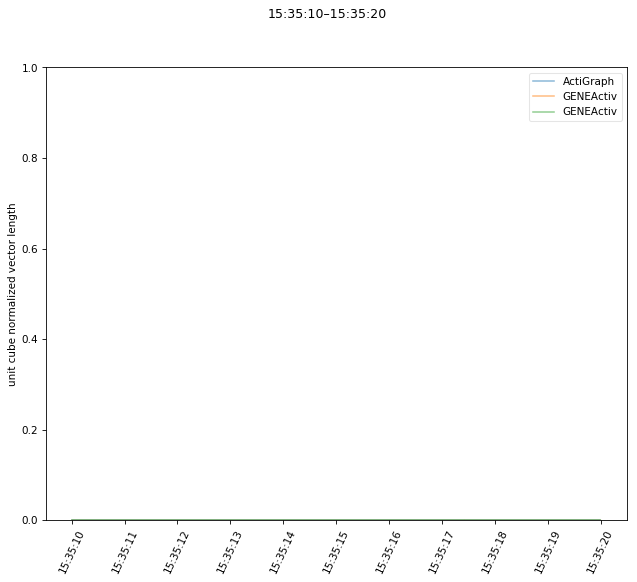

Plotting...
15:35:20–15:35:30
normalized_vector_length_ActiGraph
normalized_vector_length_GENEActiv
normalized_vector_length_GENEActiv(2)


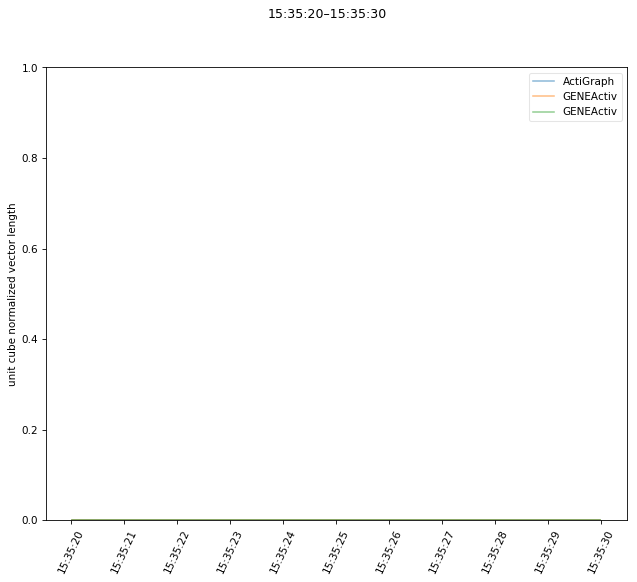

Plotting...
15:35:30–15:35:40
normalized_vector_length_ActiGraph
1.97822407421e-06
normalized_vector_length_GENEActiv(2)


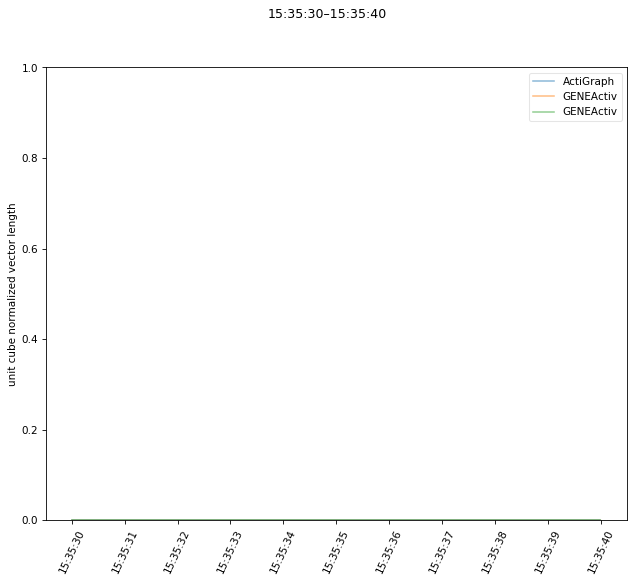

Plotting...
15:35:40–15:35:50
normalized_vector_length_ActiGraph
4.66537027592e-06
normalized_vector_length_GENEActiv(2)


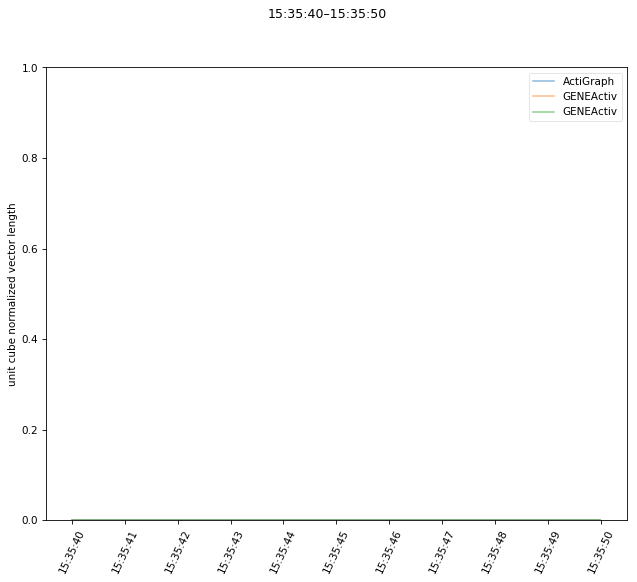

Plotting...
15:35:50–15:36:00
0.174217098416
0.144864303445
0.106211728646


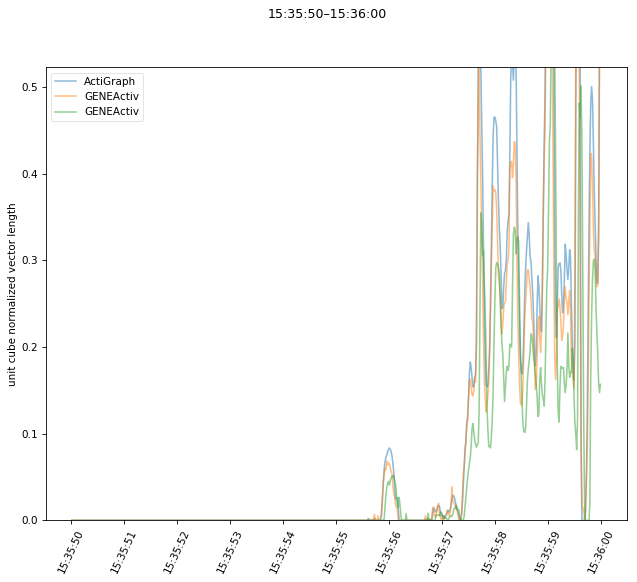

Plotting...
15:36:00–15:36:10
0.137080549746
0.112364259569
0.0861537732741


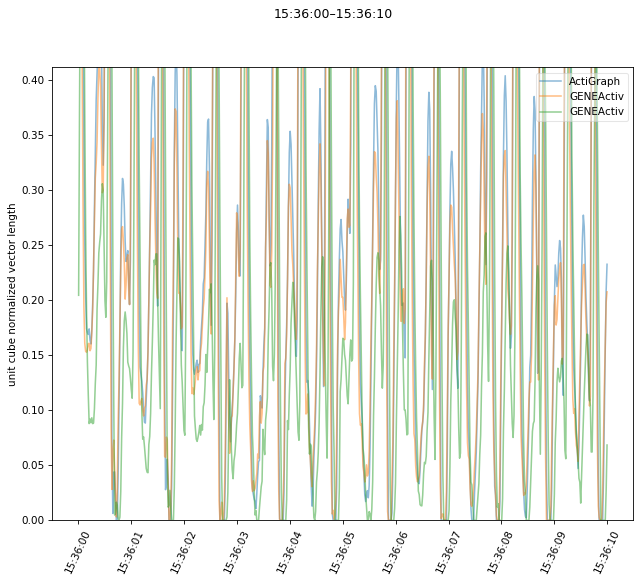

Plotting...
15:36:10–15:36:20
0.125541958338
0.102160458566
0.0782075873243


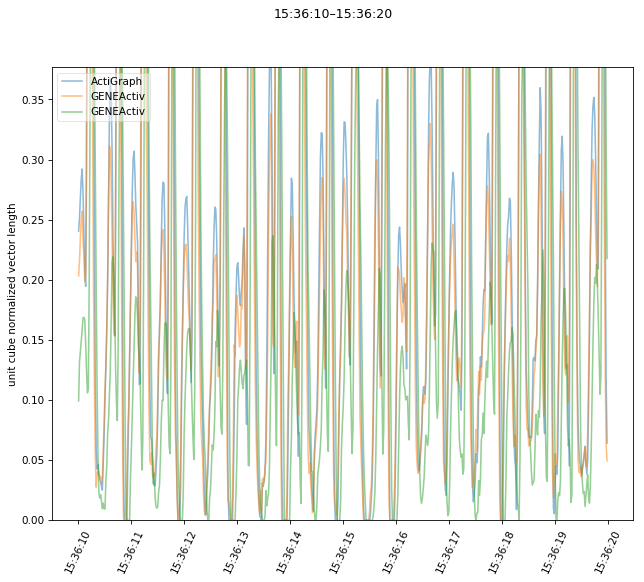

Plotting...
15:36:20–15:36:30
0.12343307446
0.099224858278
0.0770311929425


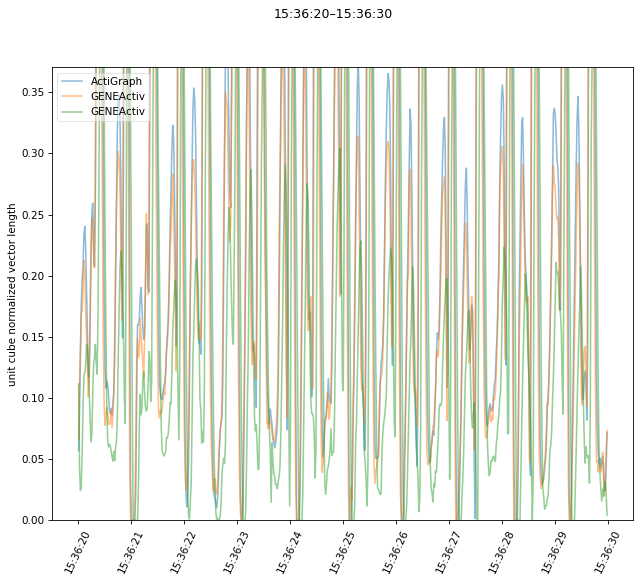

Plotting...
15:36:30–15:36:40
0.134234563069
0.110919425151
0.0804528887993


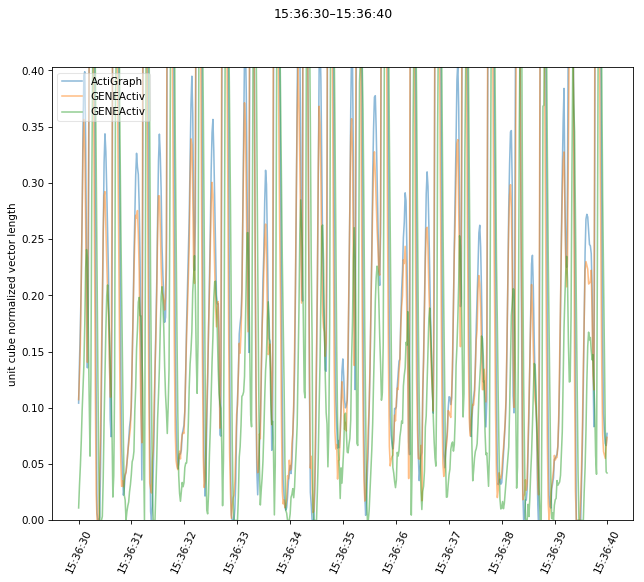

Plotting...
15:36:40–15:36:50
0.125648565842
0.102660287174
0.0764988101304


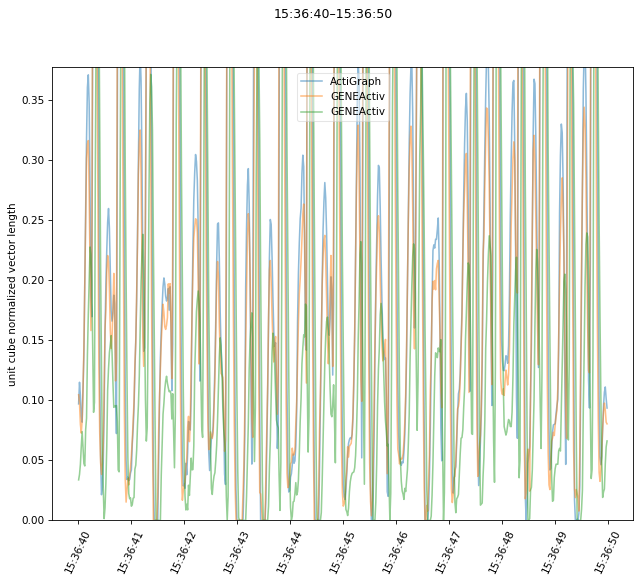

Plotting...
15:36:50–15:37:00
0.121277944793
0.105877515095
0.0664929640489


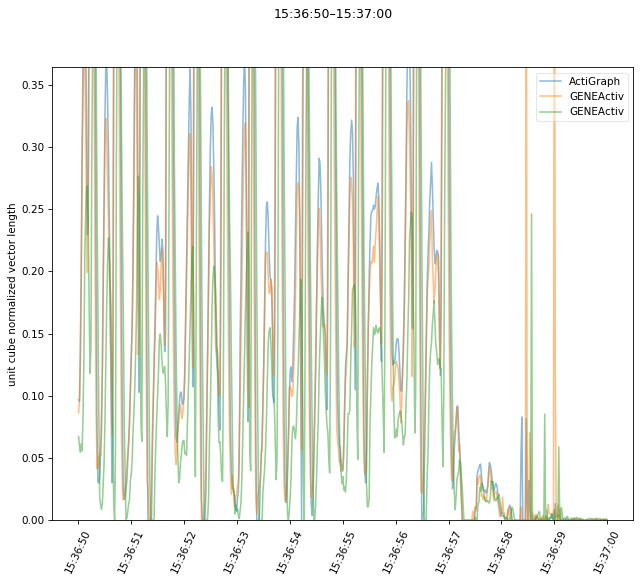

End of data.


In [14]:
start = datetime(2017,4,28,15,30) #shifted_t[0]
stop = datetime(2017,4,28,15,48) #shifted_t[-1]
plot_data = True
while start < stop and plot_data:
    new_start = start + timedelta(seconds=10)
    plot_df = cropped_df.loc[(cropped_df.index >= start) & (cropped_df.index <= new_start)].copy()
    label = '–'.join([start.strftime('%H:%M:%S'), new_start.strftime('%H:%M:%S')])
    plot_data = linechart(plot_df, label, line=True, full=False)
    #print(xcorr(plot_df['normalized_vector_length_GENEActiv'].values,
    #            plot_df['normalized_vector_length_GENEActiv(2)'].values))
    #print(xcorr(plot_df['normalized_vector_length_ActiGraph'].values,
    #            plot_df['normalized_vector_length_GENEActiv'].values))
    #print(xcorr(plot_df['normalized_vector_length_ActiGraph'].values,
    #            plot_df['normalized_vector_length_GENEActiv(2)'].values))
    start = new_start

np.shape(G1values)

start = datetime(2017, 4, 28, 15, 29)
stop = datetime(2017, 4, 28, 16, 29)
while start < stop:
    new_start = start + timedelta(seconds=30)
    plot_df = df.loc[(df.index >= start) & (df.index <= new_start)].copy()
    label = '–'.join([start.strftime('%H:%M:%S'), new_start.strftime('%H:%M:%S')])
    linechart(plot_df, label, False)
    start = new_start

start = datetime(2017, 4, 28, 15, 29)
stop = datetime(2017, 4, 28, 16, 29)
while start < stop:
    new_start = start + timedelta(seconds=30)
    plot_df = df.loc[(df.index >= start) & (df.index <= new_start)].copy()
    label = '–'.join([start.strftime('%H:%M:%S'), new_start.strftime('%H:%M:%S')])
    linechart(plot_df, label, False, True)
    start = new_start